# 14-Toxicity

Learning Objectives:
1. Learn how toxicants enter and are eliminated from the body.
2. Understand effects of toxicants, including response vs. dose
3. Use probit equations to determine response to dose. 
4. Understand exposure limits such as Threshold Limit Value (TLV) and Permissible Exposure Limit (PEL).


## Entry Routes of Toxicants
| Route | Entry | Control |
| --- | --- | --- |
| Inhalation | Lungs | Ventilation, respirators, hoods |
| Ingestion | Mouth | Hygiene, gloves, Guidelines on eating, drinking, etc |
| Injection | Skin | Gloves, protective clothing |
| Absorption | Skin | Gloves, protective clothing |

## Toxin Blood Concentration

<img src="https://github.com/clint-bg/safetyinjc/blob/main/physical/supportfiles/toxinblood.png?raw=true" width="500">

## Responses to Toxicants

Irreversible Effects:
- Cancinogens (cancer)
- Mutagens (genetic changes)
- Teratogens (birth defects)
- Reproductive toxins

Reversible Effects:
- Dermatotoxicants (skin)
- Neurotoxicants (nervous system)
- Hepatotoxicants (liver)
- Nephrotoxicants (kidneys)
- Pulmonotoxicants (lungs)
- Hemotoxicants    (blood)

## Toxin Storage and Elimination

<img src="https://github.com/clint-bg/safetyinjc/blob/main/physical/supportfiles/elimination.png?raw=true" width="500">

Excretion: kidneys (urine), liver (bile), lungs (breath), skin (sweat)

Detoxification: liver (chemical changes through enzymes)

Storage: fat, bone, hair, nails, etc.

## Dose-Response Relationships

Suppose we have the following data from a toxicology study with mice:

| Dose (mg/kg) | Response (Death) |
| --- | --- |
| 0.1 | 0 |
| 0.2 | 0 |
| 0.3 | 0 |
| 0.4 | 0 |
| 0.5 | 1 of 20 |
| 0.75 | 2 of 20 |
| 1.0 | 5 of 20 |
| 1.25 | 12 of 20 |
| 2 | 13 of 20 |
| 5 | 19 of 20|


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = {'Dose (mg/kg)': [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.25, 2, 5], 'Response (Death)': [0, 0, 0, 0, 1, 2, 5, 12, 13, 19]}
df = pd.DataFrame(data)
df['Fraction (Death)'] = df['Response (Death)'] / 20

<Axes: xlabel='Dose (mg/kg)', ylabel='Fraction (Death)'>

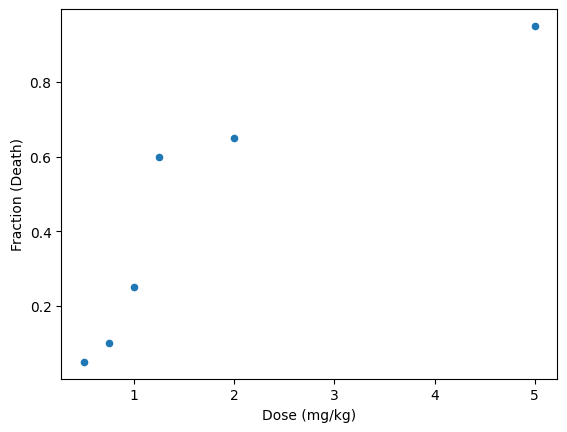

In [36]:
df.plot(x='Dose (mg/kg)', y='Fraction (Death)', kind='scatter')

Some questions we might ask:
- Were the mice that survived a lower dose then dosed with a higher dose?
- How does this toxicant affect humans? In the same way as mice?
- What is the LD50 (lethal dose for 50% of the population)?
- What would be a threshold dose? 

If we fit a response curve to the data, we can answer some of those questions.

Lets fit a gaussian curve to the data and see what we get.

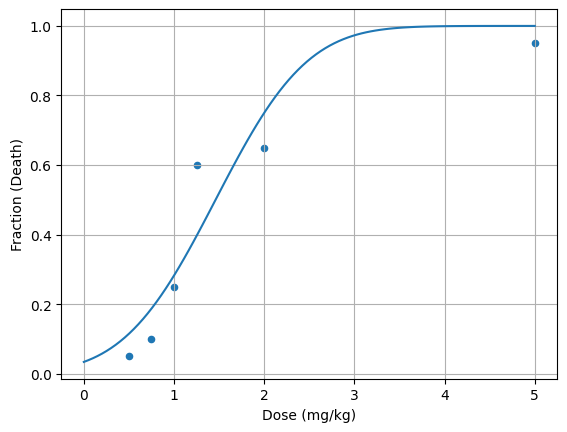

In [34]:
# fit a cumulative gaussian to the data
from scipy.optimize import curve_fit
from scipy.stats import norm

def cumulative_gaussian(x, mu, sigma):
    return norm.cdf(x, mu, sigma)

popt, pcov = curve_fit(cumulative_gaussian, df['Dose (mg/kg)'], df['Fraction (Death)'])

x = np.linspace(0, 5, 100)
y = cumulative_gaussian(x, *popt)

df.plot(x='Dose (mg/kg)', y='Fraction (Death)', kind='scatter')
plt.plot(x, y, label='fit'); plt.grid()
plt.show()


What's the cumulative distribution function for a gaussian curve?

It is the integral of the gaussian curve from negative infinity to x...

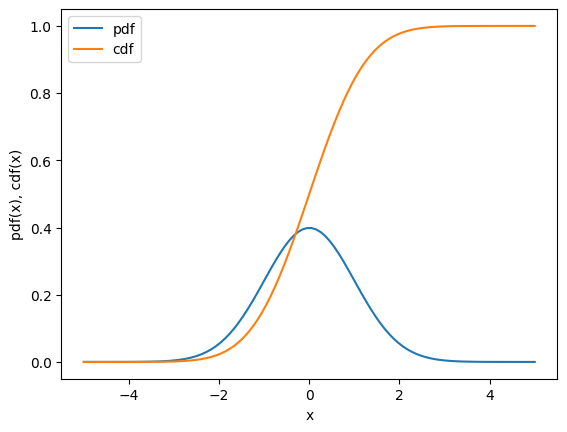

In [5]:
# plot of the gaussian curve
x = np.linspace(-5, 5, 100)
y = norm.pdf(x, 0, 1)
y2 = norm.cdf(x, 0, 1)
plt.plot(x, y, label='pdf'); 
plt.plot(x, y2, label='cdf');
plt.xlabel('x'); plt.ylabel('pdf(x), cdf(x)'); plt.legend();
plt.show()

From the above cumulative fit, we can calculate the LD50 and the threshold dose.

In [6]:
# Calculation of the LD50 and threshold dose

# LD50
mu, sigma = popt
ld50 = norm.ppf(0.5, mu, sigma) # ppf is the inverse of the cdf
#print the LD50 with 2 decimal places
print('LD50:', round(ld50, 2), 'mg/kg')

# threshold dose
threshold = norm.ppf(0.01, mu, sigma)
print(f'Threshold: {threshold:.2f} mg/kg')

LD50: 1.45 mg/kg
Threshold: -0.18 mg/kg


Here we've given an estimate of the LD50 and the threshold dose (LD01). But wait, a negative value for the dose? That doesn't make sense. 

In order to prevent that from happening, we can transform the dose or causitive variable (use the logarithmic function).

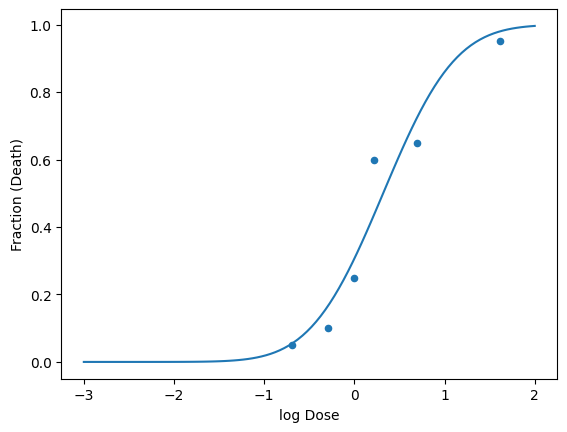

In [37]:
# log dose
df['log Dose'] = np.log(df['Dose (mg/kg)'])

# fit the cumulative gaussian to the log dose
popt, pcov = curve_fit(cumulative_gaussian, df['log Dose'], df['Fraction (Death)'])
x = np.linspace(-3, 2, 100)
y = cumulative_gaussian(x, *popt)
df.plot(x='log Dose', y='Fraction (Death)', kind='scatter')
plt.plot(x, y, label='fit'); 
plt.show()

Now lets try again on determining the LD50 and threshold dose.

In [13]:
# Calculation of the LD50 and threshold dose

# LD50
mu, sigma = popt
ld50 = np.exp(norm.ppf(0.5, mu, sigma)) # we need to transform back to the original scale with np.exp
#print the LD50 with 2 decimal places
print('LD50:', round(ld50, 2), 'mg/kg')

# threshold dose
threshold = np.exp(norm.ppf(0.01, mu, sigma)) # we need to transform back to the original scale with np.exp
print(f'Threshold: {threshold:.2f} mg/kg')

LD50: 1.37 mg/kg
Threshold: 0.33 mg/kg


There is a slight difference in the LD50, which is expected as the weighting is different for the data in log space. In this case it is more conservative.

The threshold dose (1% chance of death) is also different (not negative) and thus realistic.

### Probit Equation

It can be convenient to use the probit equation to determine the response to a dose. The probit equation is essentially the inverse of the cumulative distribution function of the normal distribution and can be use to linearize the dose-response relationship.

Transforming the fraction to a probit value...

In [15]:
# transform of the probability or fraction response to probit
def probit(p):
    return 5 + norm.ppf(p)


In [17]:
df['Probit'] = probit(df['Fraction (Death)'])

In [21]:
df

,Dose (mg/kg),Response (Death),Fraction (Death),log Dose,Probit
0,0.10,0,0.00,-2.302585,-inf
1,0.20,0,0.00,-1.609438,-inf
2,0.30,0,0.00,-1.203973,-inf
3,0.40,0,0.00,-0.916291,-inf
4,0.50,1,0.05,-0.693147,3.355146
5,0.75,2,0.10,-0.287682,3.718448
6,1.00,5,0.25,0.000000,4.325510
7,1.25,12,0.60,0.223144,5.253347
8,2.00,13,0.65,0.693147,5.385320
9,5.00,19,0.95,1.609438,6.644854


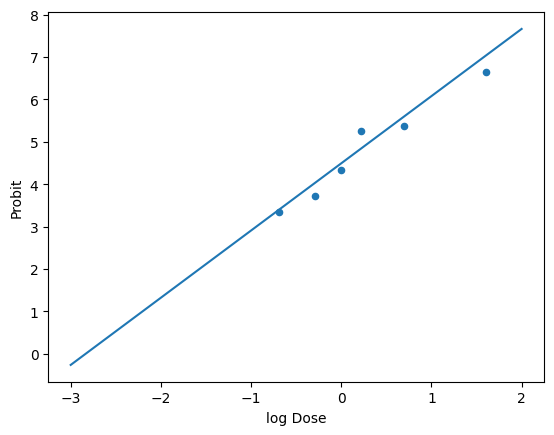

In [38]:
# plot of the data with the probit scale
df.plot(x='log Dose', y='Probit', kind='scatter')
plt.plot(x, probit(y), label='fit')

Instead of fitting a gaussian and then transforming the dose, we can fit the probit equation directly to the data. This will give us the two probit constants k1 (intercept) and k2 (slope) referenced in Table 2-5 in the textbook (Crowl and Louvar).

In [31]:
# fit a line (probit linear model) to the data
#first drop -inf values
df = df[df['Probit'] > 0]

k2,k1 = np.polyfit(df['log Dose'], df['Probit'], 1) # the first value is the slope and the second the intercept
print(f'k1: {k1:.2f}, k2: {k2:.2f}')

k1: 4.40, k2: 1.47


Once we have the probit constants, we can use them to determine the response to any dose, including the LD50 and threshold dose.

In [53]:
#using the probit constants to calculate the LD50 and threshold dose
ld50_log = (5 - k1) / k2 
ld50 = np.exp(ld50_log)
print(f'LD50: {ld50:.2f} mg/kg')

# threshold dose
threshold_log = (probit(0.01) - k1) / k2
threshold = np.exp(threshold_log)
print(f'Threshold: {threshold:.2f} mg/kg')

LD50: 1.50 mg/kg
Threshold: 0.31 mg/kg


We can also transform from probit back to percent response...

In [54]:
import math
def P(Y):
    if Y != 5:
        return 0.50*(1+(Y-5)/(abs(Y-5))*math.erf(abs(Y-5)/math.sqrt(2)))
    else:
        return 0.50

### Probit Correlation Example

Suppose we use Table 2-5 in the textbook (Crowl and Louvar) to estimate the probability of death from exposure to a fireball (say the sun). The causitive variable is $t_{exposure}\cdot I^{4/3}$/1E4 where I is the radiation intensity. Say we stay out in the sun for 8 hours. The typical radiation intensity in full sun is 1000 W/m^2. What is the probability of death?

## TLV and PEL

TLV (Threshold Limit Value) and PEL (Permissible Exposure Limit) are exposure limits for toxicants. They are typically given in units of concentration (e.g. ppm, mg/m^3).

- TLV-TWA (Time Weighted Average) is the average concentration over an 8-hour workday that is believed to be safe for most workers.
- TLV-STEL (Short Term Exposure Limit) is the maximum concentration for a short period of time (15 minutes) that is expected to be safe.
- TLV-C (Ceiling) is the maximum concentration that should never be exceeded.

These TLV values are established by the American Conference of Governmental Industrial Hygienists (ACGIH).

OSHA (Occupational Safety and Health Administration) has established PEL values which are similar to TLV values.

ILDV (Immediately Dangerous to Life and Health) is the concentration that is immediately dangerous to life and health.

### Example with Probit and TLV

Table 2-5 gives probit parameters for dying from ammonia. Calculate the LD50 from these parameters and compare it with the LD50 reported in the literature. Also, compare the TLV-TWA to determine a probability for death from the probit parameters.
